SL mult = 1.0 | TP mult = 3.0
Fetched 51,840 bars  |  2024-12-28 17:00:00 → 2025-06-26 16:55:00
Trade 1 | long | 189.56 → 191.32 | R=3.00 | Equity: 1003.00 | 2024-12-31 08:20:00
Trade 2 | short | 215.77 → 216.35 | R=-1.00 | Equity: 1002.00 | 2025-01-04 03:15:00
Trade 3 | short | 213.14 → 213.14 | R=0.00 | Equity: 1002.00 | 2025-01-05 14:05:00
Trade 4 | long | 218.70 → 218.31 | R=-1.00 | Equity: 1001.00 | 2025-01-07 00:35:00
Trade 5 | short | 196.27 → 194.76 | R=3.00 | Equity: 1004.00 | 2025-01-08 11:30:00
Trade 6 | short | 195.57 → 196.19 | R=-1.00 | Equity: 1003.00 | 2025-01-09 02:10:00
Trade 7 | long | 186.31 → 188.60 | R=3.00 | Equity: 1006.00 | 2025-01-10 02:05:00
Trade 8 | long | 192.57 → 192.07 | R=-1.00 | Equity: 1005.00 | 2025-01-10 11:10:00
Trade 9 | long | 205.03 → 204.09 | R=-1.00 | Equity: 1004.00 | 2025-01-16 11:15:00
Trade 10 | long | 243.88 → 242.33 | R=-1.00 | Equity: 1003.00 | 2025-01-18 14:20:00
Trade 11 | long | 242.38 → 240.69 | R=-1.00 | Equity: 1002.00 | 2025-01-2

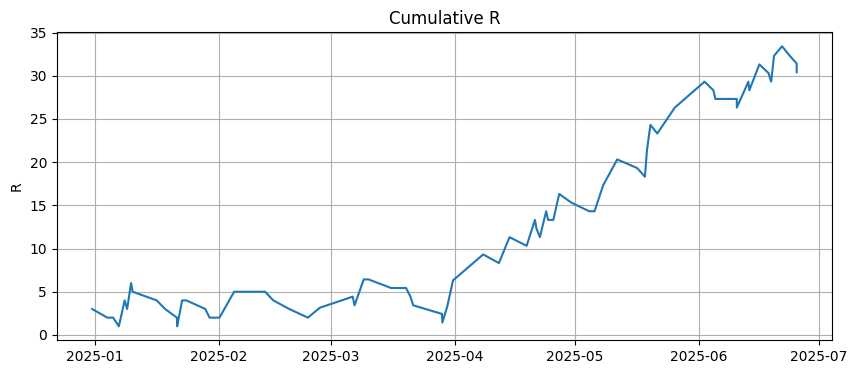

In [22]:
import pandas as pd, numpy as np, ccxt, matplotlib.pyplot as plt, importlib
import break_retest_alert as bot         
importlib.reload(bot)

print(f"SL mult = {bot.ATR_SL_MULT} | TP mult = {bot.ATR_TP_MULT}")

# ── test-parameters ──────────────────────────────────────────────────────────
COOLDOWN_BARS   = 1
LAST_FILLED_BAR = None          # gets updated below

# ── 1. fetch data (90 days of 5-minute) ─────────────────────────────────────
ex   = ccxt.bybit();   pair = "SOL/USDT:USDT"
bars = [];  since = ex.milliseconds() - 180*24*60*60*1000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(pair, "5m", since=since, limit=1000)
    if not chunk: break
    bars.extend(chunk); since = chunk[-1][0] + 1

df = pd.DataFrame(bars, columns="ts open high low close volume".split())
df.ts = pd.to_datetime(df.ts, unit="ms"); df.set_index("ts", inplace=True)
print(f"Fetched {len(df):,} bars  |  {df.index[0]} → {df.index[-1]}")

# ── 2. indicators – reuse live helper ───────────────────────────────────────
bot.add_indicators(df)

# ── 3. walk-forward back-test ───────────────────────────────────────────────
trades, equity, pos = [], 1000.0, None

for i, bar in enumerate(df.itertuples()):
    atr = bar.atr

    # ── manage open trade ───────────────────────────────────────────────────
    if pos:
        hit_tp = bar.low  <= pos.tp <= bar.high
        hit_sl = bar.low  <= pos.sl <= bar.high

        if hit_tp or hit_sl:
            exit_px = pos.tp if hit_tp else pos.sl
            pnl_r   = (exit_px - pos.entry)/pos.risk if pos.side=="long" \
                    else (pos.entry - exit_px)/pos.risk
            equity += pnl_r
            trades.append(dict(side=pos.side,
                               result="TP" if hit_tp else "SL",
                               entry_ts=pos.opened,
                               exit_ts =bar.Index,
                               entry   =pos.entry,
                               exit    =exit_px,
                               r       =pnl_r))
            print(f"Trade {len(trades):,} | {pos.side} | "
                  f"{pos.entry:.2f} → {exit_px:.2f} | R={pnl_r:.2f} | "
                  f"Equity: {equity:.2f} | {bar.Index}")
            pos, LAST_FILLED_BAR = None, i                       # ← update
        else:
            # BE-lock then +2 R trailing
            if not pos.breakeven:
                moved = (bar.close >= pos.entry + bot.BREAKEVEN_AFTER_ATR*atr
                         if pos.side=="long"
                         else bar.close <= pos.entry - bot.BREAKEVEN_AFTER_ATR*atr)
                if moved:
                    pos.sl = pos.entry;  pos.breakeven = True
            else:
                two_r = pos.entry + 2*pos.risk if pos.side=="long" else pos.entry-2*pos.risk
                if   pos.side=="long"  and bar.close >= two_r:
                    pos.sl = max(pos.sl, bar.close-atr)
                elif pos.side=="short" and bar.close <= two_r:
                    pos.sl = min(pos.sl, bar.close+atr)

    # ── new entry?  honour cool-down ────────────────────────────────────────
    if (LAST_FILLED_BAR is None or i - LAST_FILLED_BAR >= COOLDOWN_BARS) and pos is None:
        sig = bot.qualified_signal(df.iloc[:i+1])
        if sig:
            side  = "long" if sig=="bull" else "short"
            entry = bar.close
            sl    = entry-bot.ATR_SL_MULT*atr if side=="long" else entry+bot.ATR_SL_MULT*atr
            tp    = entry+bot.ATR_TP_MULT*atr if side=="long" else entry-bot.ATR_TP_MULT*atr
            risk  = abs(entry-sl)
            pos   = bot.Position(side, entry, sl, tp, bar.Index, risk)
            LAST_FILLED_BAR = i                                         # ← update

# ── 4. summary ──────────────────────────────────────────────────────────────
res = pd.DataFrame(trades)
if res.empty:
    print("No trades fired.")
else:
    print(f"Trades: {len(res)} | Win-rate: {(res.result=='TP').mean():.1%} | "
          f"Total R: {res.r.sum():.2f} | Equity: {equity:.2f}")
    plt.figure(figsize=(10,4))
    plt.plot(res.exit_ts, res.r.cumsum()); plt.grid()
    plt.title("Cumulative R"); plt.ylabel("R"); plt.show()
